In [109]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import is_numeric_dtype
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [103]:
# makni sve sklearn warninge da ne vrište kad se pali logreg grid search
import warnings

warnings.filterwarnings("ignore", module="sklearn")

In [2]:
df=pd.read_csv("CBWDB.csv")
df

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex,BWt(kg),LNH
0,BPL,23.0,146.0,A(+ve),1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,T,F,2.7,2.0
1,BPL,25.0,165.0,NIL,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,T,M,2.9,2.0
2,BPL,24.0,155.0,B(+ve),1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,T,M,2.4,1.0
3,BPL,19.0,154.0,NIL,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,T,F,2.6,2.0
4,BPL,21.0,150.0,NIL,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,T,F,2.3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,BPL,26.0,NaN,NaN,0.0,3.0,39.0,40.0,110.0,78.0,112.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1796,BPL,22.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1797,BPL,24.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1798,BPL,24.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_filtered=df[df["LNH"].isna()==False]
print("Nedostajuće vrijednosti po stupcima:")
print(df_filtered.isna().sum())
print("\nBroj redaka nakon filtriranja: ",len(df_filtered))

Nedostajuće vrijednosti po stupcima:
SEC             200
Age(years)        3
Height(cm)      128
Bgroup          367
Parity            0
ANC               0
Iwt(kg)          12
FWt(kg)          13
IBP_sys           4
IBP_dias          4
FBP_sys           6
FBP_dias          6
IHb(gm%)        103
FHb(gm%)        102
BS(RBS)         531
Term/Preterm    133
Sex              11
BWt(kg)           0
LNH               0
dtype: int64

Broj redaka nakon filtriranja:  1072


Korelacija Bgroup-BWt:
-0.06242962414091278

Korelacija BS-BWt:
0.21073540683351974


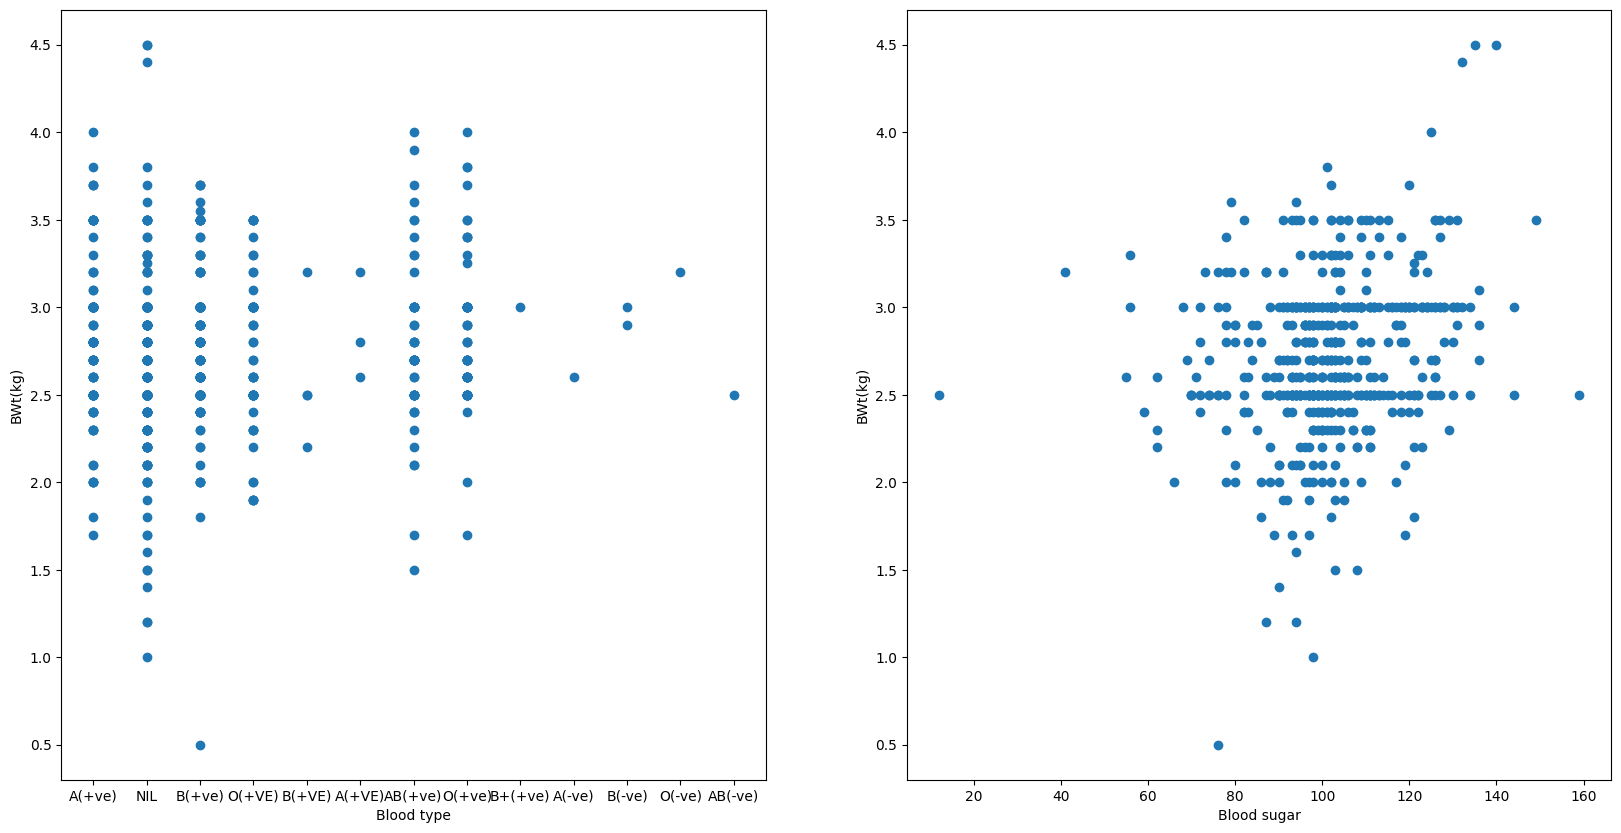

In [4]:
df_bgroup=df_filtered[df_filtered["Bgroup"].isna()==False]


print("Korelacija Bgroup-BWt:")
print(np.corrcoef(df_bgroup["Bgroup"].astype("category").cat.codes,df_bgroup["BWt(kg)"])[0,1])

fig,ax=plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(df_bgroup["Bgroup"],df_bgroup["BWt(kg)"])
ax[0].set_xlabel("Blood type")
ax[0].set_ylabel("BWt(kg)")

df_bs=df_filtered[df_filtered["BS(RBS)"].isna()==False]

print("\nKorelacija BS-BWt:")
print(np.corrcoef(df_bs["BS(RBS)"],df_bs["BWt(kg)"])[0,1])

ax[1].scatter(df_bs["BS(RBS)"],df_bs["BWt(kg)"])
ax[1].set_xlabel("Blood sugar")
ax[1].set_ylabel("BWt(kg)")
plt.show()

In [5]:
df_filtered=df_filtered.drop(columns=["Bgroup","BWt(kg)"])

In [6]:
#Micanje nebitnih slucaja (transici i debeli) i redaka bez ocitanja cukra
df_filtered=df_filtered[(df_filtered["LNH"]!=3) & (df_filtered["Sex"]!="T") & (df_filtered["BS(RBS)"].isna()==False)]

print(df_filtered.isna().sum())
print("Broj točaka: ",len(df_filtered))

SEC             35
Age(years)       0
Height(cm)       0
Parity           0
ANC              0
Iwt(kg)          0
FWt(kg)          0
IBP_sys          0
IBP_dias         0
FBP_sys          0
FBP_dias         0
IHb(gm%)         0
FHb(gm%)         0
BS(RBS)          0
Term/Preterm     2
Sex              1
LNH              0
dtype: int64
Broj točaka:  537


In [7]:
print('Broj zapisa prije izbacivanja outliera:', len(df_filtered))
df_copy = df_filtered.copy()

for col in df_copy.columns:
    if is_numeric_dtype(df_copy[col]):
        z = np.abs(stats.zscore(df_copy[col]))
        outlier_indices = np.where(z > 3.0)[0]
        df_copy = df_copy.drop(df_copy.index[outlier_indices])

df_filtered=df_copy.copy()
print('Broj zapisa nakon izbacivanja outliera:', len(df_copy))

Broj zapisa prije izbacivanja outliera: 537
Broj zapisa nakon izbacivanja outliera: 454


In [8]:
print(df_copy.isna().sum())

SEC             29
Age(years)       0
Height(cm)       0
Parity           0
ANC              0
Iwt(kg)          0
FWt(kg)          0
IBP_sys          0
IBP_dias         0
FBP_sys          0
FBP_dias         0
IHb(gm%)         0
FHb(gm%)         0
BS(RBS)          0
Term/Preterm     1
Sex              1
LNH              0
dtype: int64


In [9]:
cat_cols=["SEC","Sex","Term/Preterm"]
for col in cat_cols:
    df_copy[col]=df_copy[col].fillna(df_copy[col].mode()[0])

In [10]:
for col in df_filtered.columns:
    if col in cat_cols:
        df_filtered[col]=df_filtered[col].astype('category').cat.codes
    else:
        df_filtered[col]=(df_filtered[col]-df_filtered[col].min())/(df_filtered[col].max()-df_filtered[col].min())

df_filtered

,SEC,Age(years),Height(cm),Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex,LNH
0,1,0.454545,0.456140,0.5,1.0,0.111111,0.194444,0.636364,0.700,0.594595,0.512195,0.476190,1.000000,0.386364,1,0,1.0
2,1,0.500000,0.614035,0.5,0.5,0.527778,0.555556,0.257576,0.050,0.459459,0.512195,0.714286,0.692308,0.522727,1,1,0.0
3,1,0.272727,0.596491,0.5,0.0,0.527778,0.416667,0.242424,0.050,0.324324,0.268293,0.476190,0.500000,0.534091,1,0,1.0
4,1,0.363636,0.526316,0.5,1.0,0.305556,0.361111,0.393939,0.250,0.459459,0.512195,0.238095,0.423077,0.488636,1,0,0.0
5,1,0.272727,0.526316,0.0,1.0,0.388889,0.527778,0.393939,0.500,0.594595,0.756098,0.238095,0.346154,0.420455,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,1,0.681818,0.385965,0.5,1.0,0.333333,0.361111,0.393939,0.400,0.378378,0.487805,0.452381,0.576923,0.681818,1,1,1.0
1589,1,0.772727,0.438596,0.5,0.5,0.638889,0.611111,0.530303,0.350,0.621622,0.658537,0.547619,0.500000,0.681818,0,1,1.0
1600,1,0.409091,0.526316,0.0,1.0,0.611111,0.638889,0.454545,0.525,0.351351,0.292683,0.119048,0.576923,0.352273,1,1,1.0
1607,1,0.409091,0.298246,0.0,1.0,0.361111,0.361111,0.454545,0.300,0.432432,0.317073,0.476190,0.519231,0.181818,1,0,1.0


### Let the fun begin... Modeli!

In [11]:
X=df_filtered.drop(columns=["LNH"]).to_numpy()
y=df_filtered["LNH"].to_numpy()

#X=df_filtered.drop(columns="LNH")
#y=df_filtered["LNH"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
len(y_train),len(y_test)

(317, 137)

In [106]:
#fja za provjeru metrika na test podacima
def test_model(classifier, X_train, y_train, X_test, y_test):

    classifier.fit(X_train,y_train)

    y_pred_train=classifier.predict(X_train)
    y_pred_test=classifier.predict(X_test)

    print("Train accuracy, precision, recall, F1: {:.3f} {:.3f} {:.3f} {:.3f}".format(accuracy_score(y_train,y_pred_train),precision_score(y_train,y_pred_train),recall_score(y_train,y_pred_train),f1_score(y_train,y_pred_train)))

    print("Test accuracy, precision, recall, F1: {:.3f} {:.3f} {:.3f} {:.3f}".format(accuracy_score(y_test,y_pred_test),precision_score(y_test,y_pred_test),recall_score(y_test,y_pred_test),f1_score(y_test,y_pred_test)))

    print(confusion_matrix(y_test,y_pred_test))

# fja za pronalazak najboljih parametara
def test_parameters(classifier, X_train, y_train, params_search_space):
    criteria_metric = "f1"

    gs = GridSearchCV(estimator=classifier, 
                      param_grid=params_search_space,
                      scoring=(criteria_metric),
                      cv=5,
                      return_train_score=True)
    gs.fit(X_train, y_train)

    print(f"Best parameter set: {gs.best_params_}")

    if len(params_search_space) == 1:
        param_name = list(params_search_space.keys())[0]
        param_values = gs.cv_results_[f'param_{param_name}'].data
        mean_test_scores = gs.cv_results_['mean_test_score']
        mean_train_scores = gs.cv_results_['mean_train_score']

        plt.figure(figsize=(8, 6))
        plt.plot(param_values, mean_test_scores, label='Test Score', color='blue')
        plt.plot(param_values, mean_train_scores, label='Train Score', color='green')
        plt.xscale('log')
        plt.xlabel(f'{param_name}')
        plt.ylabel(f'{criteria_metric}')
        plt.title(f'{type(classifier).__name__} Grid Search Results')
        plt.legend()
        plt.grid(True)
        plt.show()

    return gs.best_params_

In [67]:
## stavi na False ak ne zelis vrtit grid search na svakom modelu
grid_search_mode = True

In [76]:
# y_train=1-y_train
# y_test=1-y_test

Best parameter set: {'var_smoothing': np.float64(0.3338285864731761)}


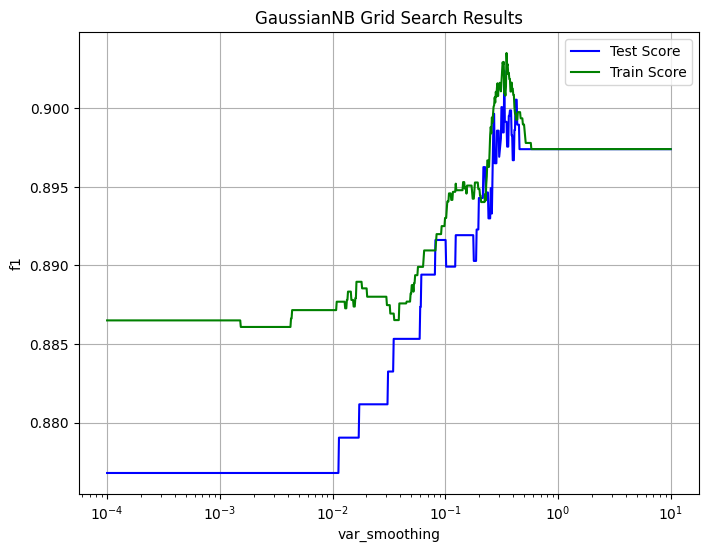

Train accuracy, precision, recall, F1: 0.826 0.831 0.988 0.903
Test accuracy, precision, recall, F1: 0.803 0.823 0.964 0.888
[[  3  23]
 [  4 107]]


In [107]:
gnb=GaussianNB()

if grid_search_mode:
    gnb_best_params = test_parameters(gnb, X_train, y_train, {
        'var_smoothing': np.logspace(1,-4, num=1000)
    })
    gnb.set_params(**gnb_best_params)

test_model(gnb, X_train, y_train, X_test, y_test)

In [ ]:
rfc=RandomForestClassifier(n_estimators=101,criterion="entropy",random_state=42,bootstrap=True,max_depth=3,class_weight="balanced_subsample")

if grid_search_mode:
    rfc_best_params = test_parameters(rfc, X_train, y_train, {
        'n_estimators': np.linspace(10, 120, 5, dtype=int).tolist(),
        'max_depth': np.linspace(5, 50, 5, dtype=int).tolist(),
        'min_samples_split': np.linspace(2, 10, 4, dtype=int).tolist(),
        'min_samples_leaf': [1, 2, 4]
    })
    rfc.set_params(**rfc_best_params)

test_model(rfc, X_train, y_train, X_test, y_test)

Best parameter set: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 92}
Train accuracy, precision, recall, F1: 1.000 1.000 1.000 1.000
Test accuracy, precision, recall, F1: 0.803 0.818 0.973 0.889
[[  2  24]
 [  3 108]]


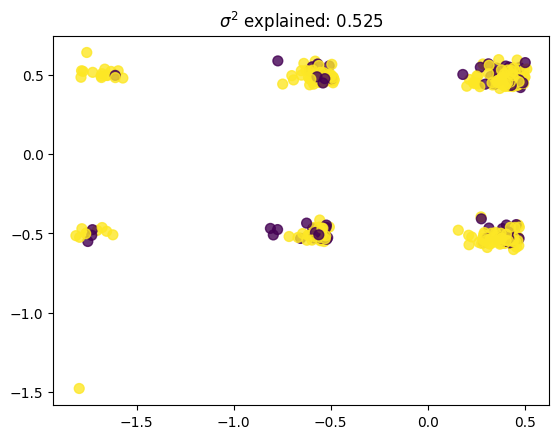

In [83]:
#iz nekog razloga tsne baca gresku. nije bitno jer imamo isti problem ka prije, vidljiv iz pca

pca=PCA(n_components=2)

X_pca=pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50, alpha=0.8)
plt.title("$\sigma^2$ explained: {:.3f}".format(sum(pca.explained_variance_ratio_)))
plt.show()

In [114]:
svc=SVC(kernel="rbf",gamma=.3,C=1,class_weight="balanced")

if grid_search_mode:
    svc_best_params = test_parameters(svc, X_train, y_train, {
        'C': np.logspace(-3, 3, 10),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [1, 2, 3, 4],
        'gamma': ['scale', 'auto'] + list(np.logspace(-4, 2, 7)),
        'coef0': [0.0, 0.1, 0.5, 1.0],
        })
    svc.set_params(**svc_best_params)

test_model(svc, X_train[:,:-1], y_train, X_test[:,:-1], y_test)

Best parameter set: {'C': np.float64(0.46415888336127775), 'coef0': 0.0, 'degree': 1, 'gamma': np.float64(100.0), 'kernel': 'rbf'}
Train accuracy, precision, recall, F1: 1.000 1.000 1.000 1.000
Test accuracy, precision, recall, F1: 0.810 0.810 1.000 0.895
[[  0  26]
 [  0 111]]


In [115]:
def moving_average_categorical(df,columns,window_size):
    for col in columns:
        for i in range(len(df)):
            if pd.isna(df.loc[i, col]):
                start = max(0, i - window_size)
                end = min(len(df), i + window_size + 1)
    
                nearby_values = df[col].iloc[start:end].dropna()

                df.at[i, col] = nearby_values.mode()
                
    return df

#df1=moving_average_categorical(df,["Sex"],3)
#plt.plot(df1["BS(RBS)"])

In [113]:
mlp = MLPClassifier(random_state=42)
if grid_search_mode:
    mlp_best_params = test_parameters(mlp, X_train, y_train, {
        'hidden_layer_sizes': [(5,), (10,), (5,2), (10,5,2)],
        'solver': ['adam', 'sgd', 'lbfgs'],
        'alpha': np.logspace(-5, 5, 11),
        'learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1]
    })
    mlp.set_params(**mlp_best_params)

test_model(mlp, X_train, y_train, X_test, y_test)

Best parameter set: {'alpha': np.float64(0.01), 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01, 'solver': 'adam'}
Train accuracy, precision, recall, F1: 0.833 0.847 0.969 0.904
Test accuracy, precision, recall, F1: 0.818 0.831 0.973 0.896
[[  4  22]
 [  3 108]]


In [108]:
lr = LogisticRegression()

if grid_search_mode:
    lr_best_params = test_parameters(lr, X_train, y_train, {
        'C': np.logspace(-4, 4, 10),
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-4, 1e-3, 1e-2],
    })
    lr.set_params(**lr_best_params)

test_model(lr, X_train, y_train, X_test, y_test)

Best parameter set: {'C': np.float64(2.782559402207126), 'max_iter': 50, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.01}
Train accuracy, precision, recall, F1: 0.849 0.855 0.981 0.913
Test accuracy, precision, recall, F1: 0.810 0.835 0.955 0.891
[[  5  21]
 [  5 106]]
